# Clustering evaluation on high dimensional data

This is an addition to the simplices study performed in GraphClustering_cliques_preservation.ipynb.
Here we look at the minimum umap weights of the simplices. We want to see if simplices that are internal to ground truth parts have higher minimum weights than simplices that are external (split by ground truth partition).

Edges that are part of internal simplices (internal w.r.t. the ground truth partition) have higher minimal UMAP weights. However, the distributions of internal vs. external simplex weights are not easily separable. Both are skewed towards small values, the internal weights distribution has a longer tail. 

TODO: it appears interesting to look into the persistence over simplex weight. This is, we start by grouping simplices above a certain weight and lower that weight. Study the persistence of this tree over the weight. 

In [1]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings']


In [2]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import cluster
from IPython.display import display, Markdown, Latex

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import igraph as ig
import leidenalg as la
import cdlib.algorithms as cd
import itertools
import collections

from community import community_louvain

sns.set()

In [204]:
def mapping_partitions(ground_truth, clustering_labels):
    partition_mapping = []
    cl_max = np.max(clustering_labels)
    gt_max = np.max(ground_truth)
    for j in range(gt_max+1):
        for i in range(cl_max+1):       
            cl_indicator = (clustering_labels==i)
            gt_indicator = (ground_truth==j)
            if(sum(cl_indicator&gt_indicator) > 0.5*min(sum(cl_indicator), sum(gt_indicator))):
                partition_mapping.append((j,i))
    return(pd.DataFrame(partition_mapping, columns=['ground_truth', 'cluster']))

def clique_per_cluster(G, clustering_labels, x):
    cliques_part = []
    for d in range(np.max(clustering_labels)+1):
        sg = G.subgraph([i for i in range(G.vcount()) if clustering_labels[i]==d])
        cliques_part.append([len(sg.cliques(min=k,max=k)) for k in range(1, x+1)])
    res = pd.DataFrame(cliques_part, columns=[f'{str(i)}-clique' for i in range(1, x+1)])
    return(res)

def clique_preservation(G, ground_truth, clustering_labels, max_clique = 5):
    part_map = mapping_partitions(ground_truth, clustering_labels)
    cl_stats = clique_per_cluster(G, clustering_labels, x=max_clique)
    gt_stats = clique_per_cluster(G, ground_truth, x=max_clique)
    clique_per_part = part_map.merge(cl_stats, left_on='cluster', right_index=True).merge(gt_stats, left_on='ground_truth', right_index=True, suffixes=('_cl', '_gt'))
    
    gt_summary = gt_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    gt_summary['Preserved in'] = 'Ground Truth'
    cl_summary = cl_stats.sum().reset_index(name='Count').rename(columns={'index': 'Structure'})
    cl_summary['Preserved in'] = 'Leiden'
    all_summary = gt_summary.copy()
    all_summary['Count'] = [len(G.cliques(min=k,max=k)) for k in range(1, 5+1)]
    all_summary['Preserved in'] = 'All'
    all_summary['Structure'] = gt_summary.Structure
    clique_summary = pd.concat([all_summary, gt_summary, cl_summary])
    return(clique_per_part, clique_summary)     

# For all triangles in G, assign a weight which is the minimum (UMAP) weight of its edges. 
# For each edge, assign the maximum weight of all triangles that includes it.
# Returns a data frame with all edges 
def edge_min_simplex_weight(G, k=3, weight='weight', enrich_graph=False):
    simplices = G.cliques(min=k, max=k)
    edge_properties = []
    clique_properties = []
    for x in simplices:
        edges_id = G.get_eids([pair for pair in itertools.combinations(x, r=2)])
        weights = [e[weight] for e in ig.EdgeSeq(G, edges_id)]
        internal = np.all([e['internal'] for e in ig.EdgeSeq(G, edges_id)])
        edge_properties += [[e, min(weights), np.average(weights), internal] for e in edges_id]
        clique_properties.append([x, edges_id, min(weights)])
    edge_clique = pd.DataFrame(edge_properties, columns=['eid', 'min_val', 'mean_val', 'internal']).groupby('eid').max().reset_index()
    cliques = pd.DataFrame(clique_properties, columns=['simplex_vid', 'simplex_eid', 'simplex_weight'])
    if(enrich_graph):
        name = f'simplex_weight_inv'
        G.es[name] = 2
        G.es[list(edge_clique.eid)][name] = 1-edge_clique.min_val

    return(cliques, edge_clique, G)

# Pendigits

In [83]:
dataset_id
set_op_mix_ratio = 0
raw_data, targets, dataset_name = get_dataset(dataset_id)
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

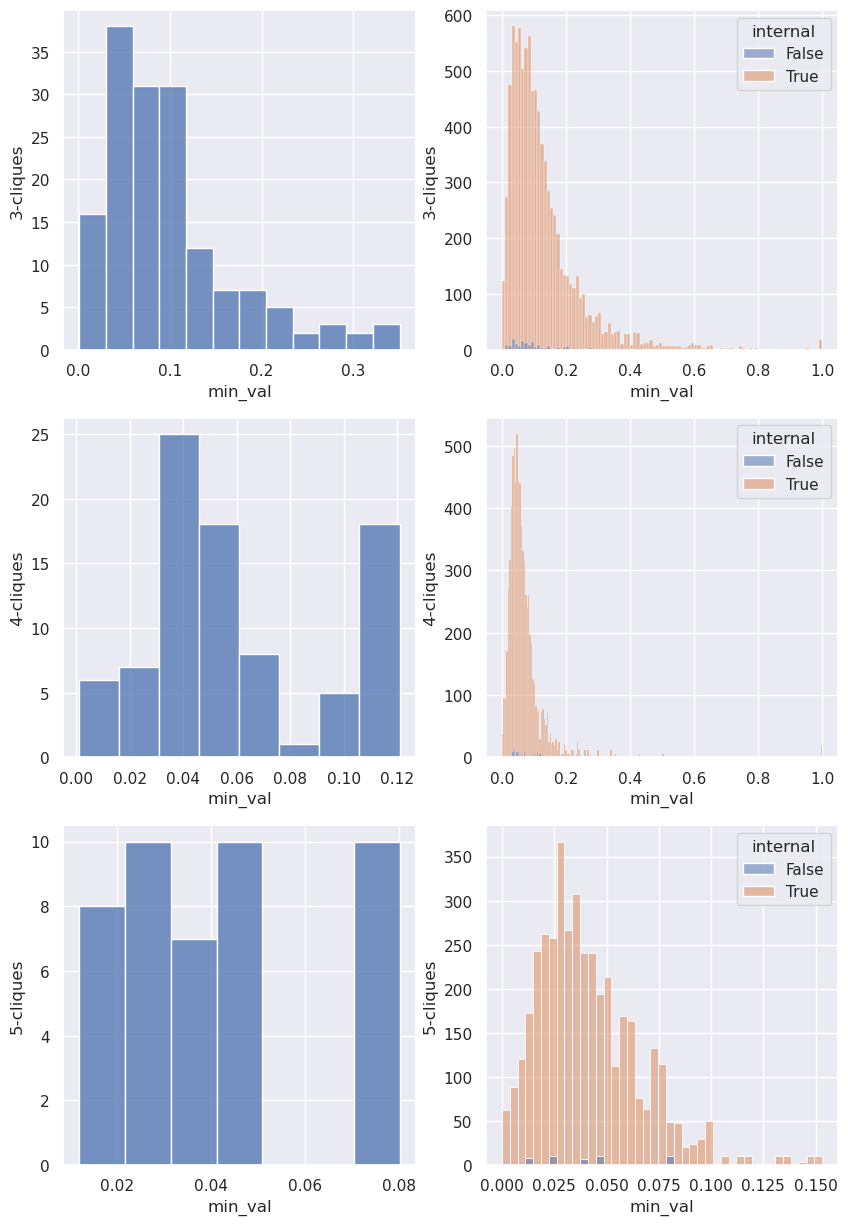

In [84]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
edge_cliques = [edge_min_simplex_weight(G, k=i, weight='weight') for i in [3,4,5]]
for i in [3,4,5]:
    edge_clique = edge_cliques[i-3]
    sns.histplot(edge_clique[~edge_clique.internal].min_val, ax=ax[i-3, 0])
    sns.histplot(data = edge_clique, x = 'min_val', hue='internal', ax=ax[i-3, 1])
    ax[i-3, 0].set(ylabel=f'{i}-cliques')
    ax[i-3, 1].set(ylabel=f'{i}-cliques')

In [90]:
G_sub = G.copy()
G_sub.delete_edges(list(edge_cliques[0].eid[edge_cliques[0].min_val<0.2]))

In [91]:
cc = G_sub.components()
len(cc)

2075

# Run the same analysis on all other datasets

In [72]:
def what_we_do_here(dataset_id, set_op_mix_ratio=1.0):
    raw_data, targets, dataset_name = get_dataset(dataset_id)
    description = 'fuzzy union'
    if(set_op_mix_ratio == 0):
        description = 'fuzzy intersection'    
    display(Markdown(f'## {dataset_name} with {description}'))
    G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
    G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

    ec = la.find_partition(G, la.ModularityVertexPartition)
    clustering_labels = np.array(ec.membership)
    G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')

    edge_cliques = [edge_min_simplex_weight(G, k=i, weight='weight') for i in [3,4]]
    n_cliques = [3+i for i, df in enumerate(edge_cliques) if df.shape[0]>0]
    n = len(n_cliques)

    fig, ax = plt.subplots(n, 2, figsize=(10, 5*n))
    for i in n_cliques:
        edge_clique = edge_cliques[i-3]
        toplot = np.any(~edge_clique.internal)
        sns.histplot(edge_clique[~edge_clique.internal].min_val, ax=ax[i-3, 0])
        sns.histplot(data = edge_clique, x = 'min_val', hue='internal', ax=ax[i-3, 1])            
        ax[i-3, 0].set(ylabel=f'{i}-cliques')
        ax[i-3, 1].set(ylabel=f'{i}-cliques')
    plt.show()
    return(edge_cliques)

## coil with fuzzy union

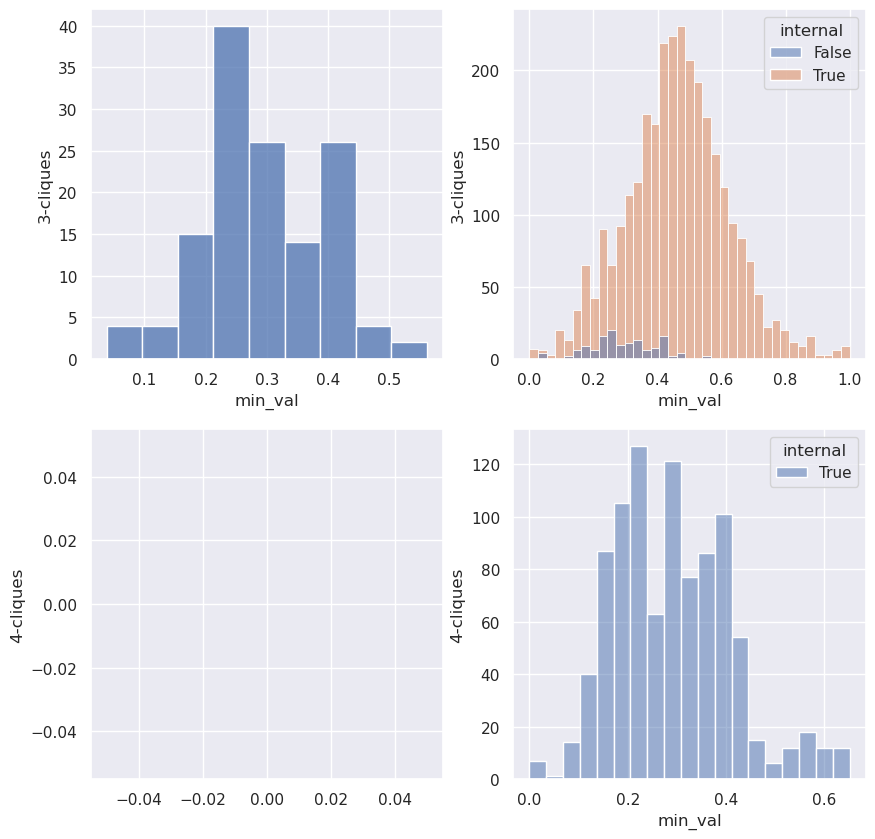

## coil with fuzzy intersection

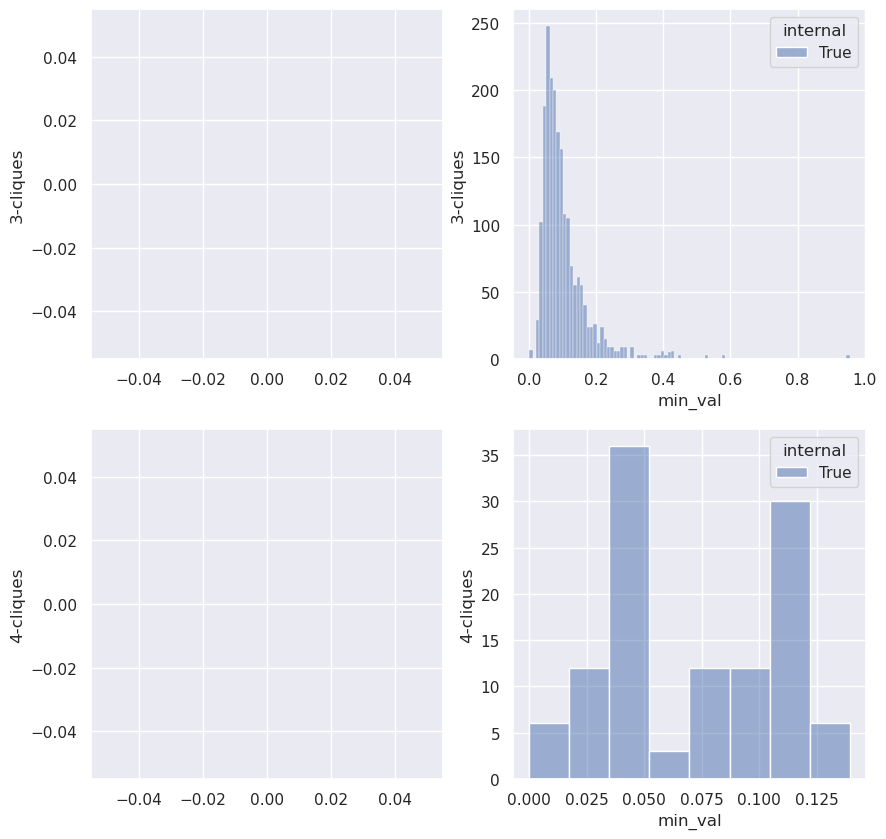

## mnist with fuzzy union

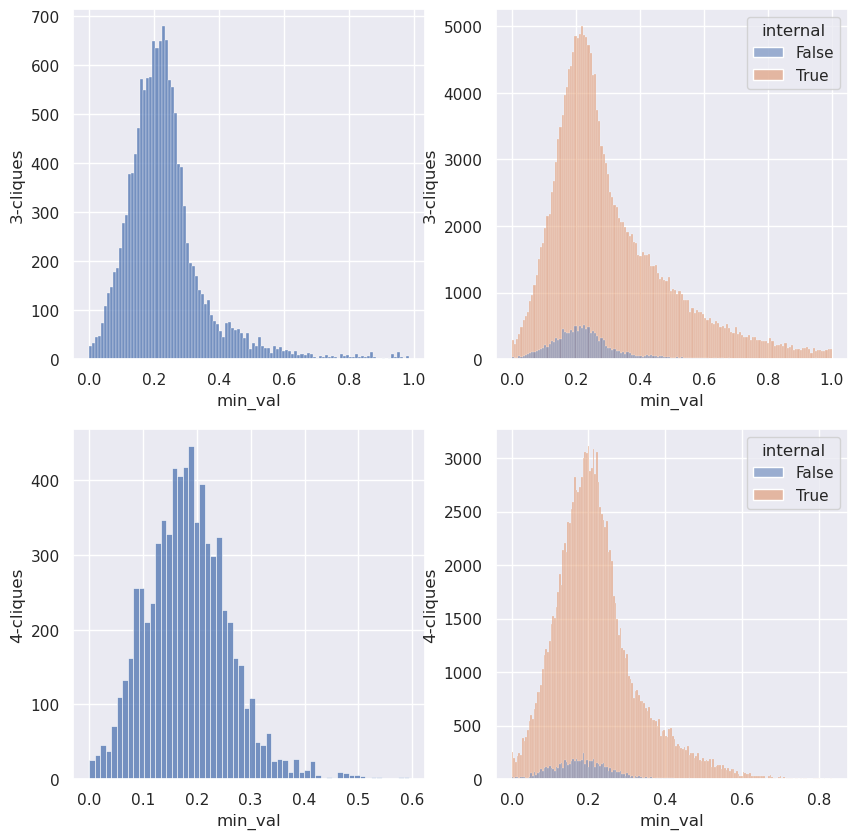

## mnist with fuzzy intersection

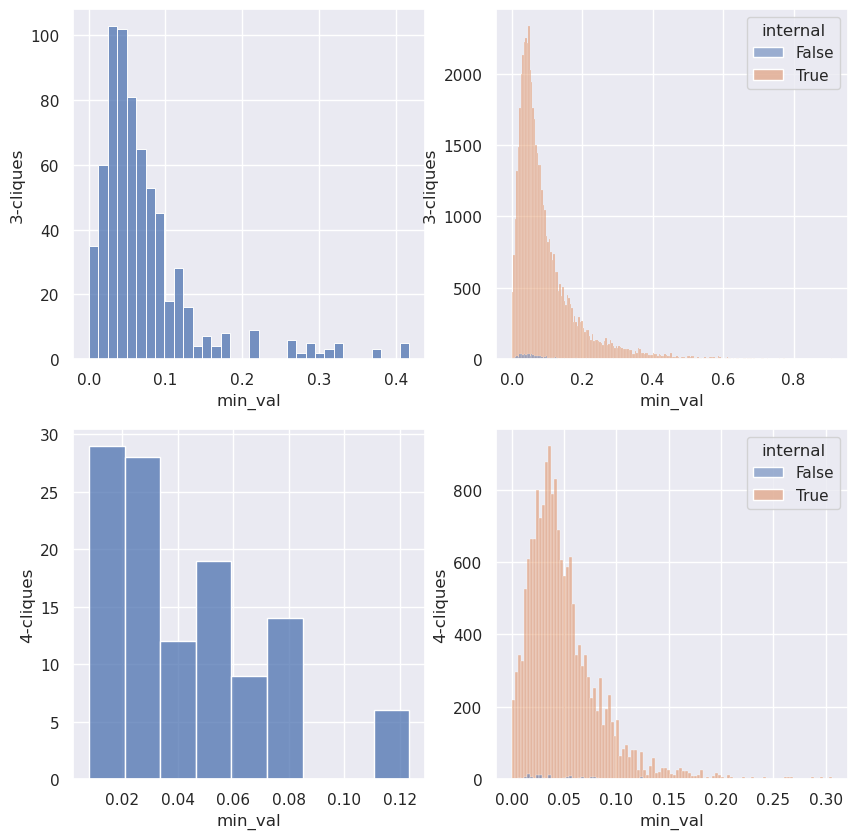

## usps with fuzzy union

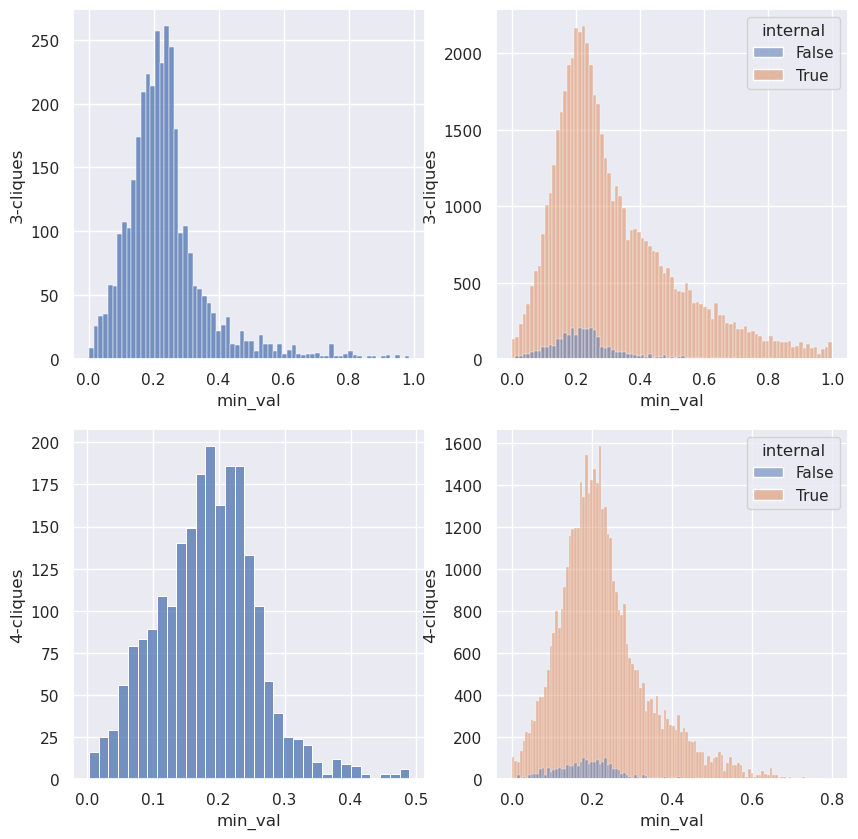

## usps with fuzzy intersection

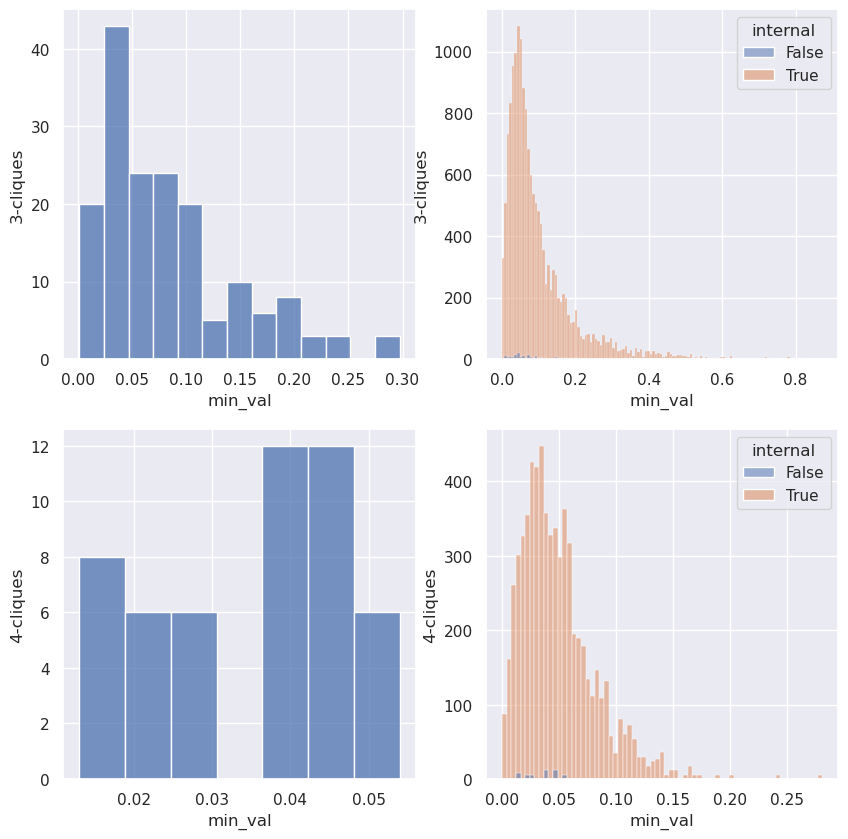

## buildings with fuzzy union

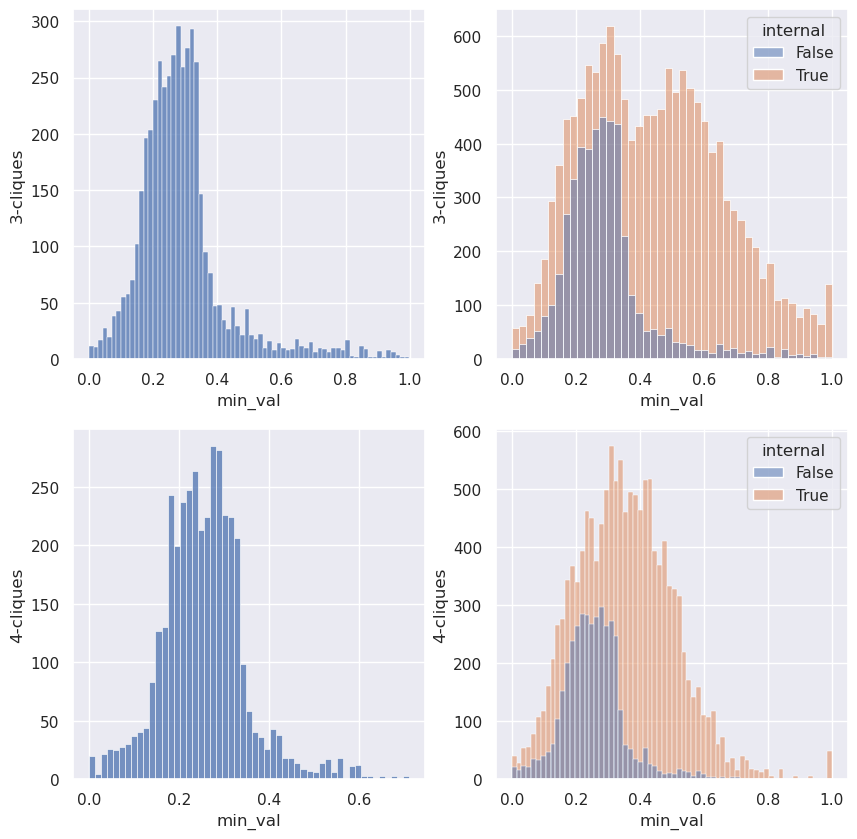

## buildings with fuzzy intersection

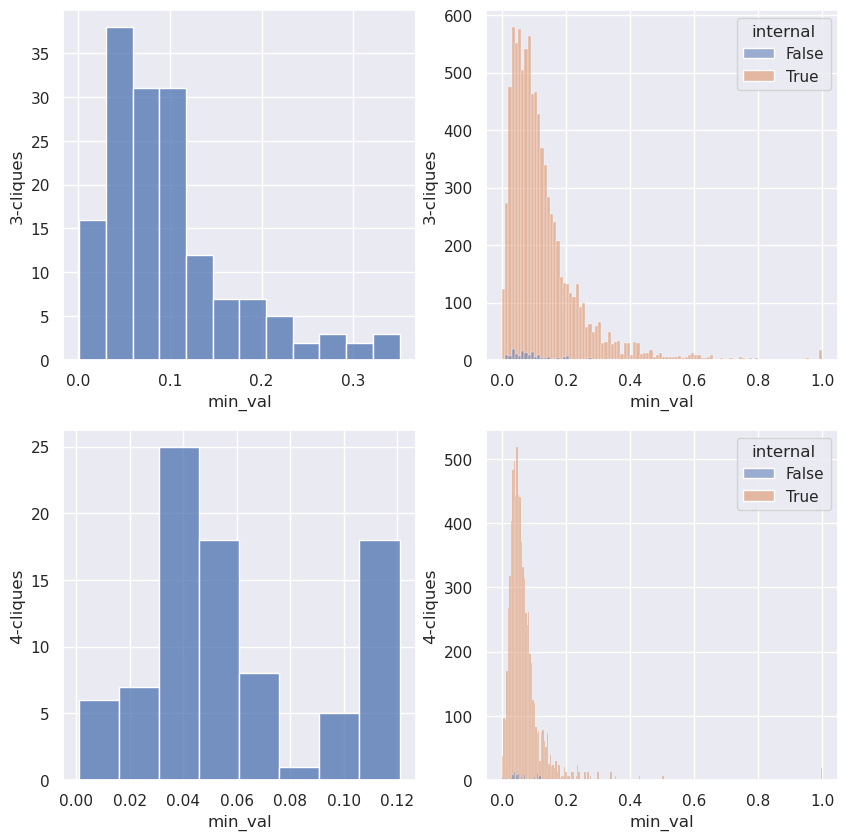

In [73]:
for dataset_id in [0, 1,2,3,4]:
    edge_cliques = what_we_do_here(dataset_id, set_op_mix_ratio=1)
    edge_cliques = what_we_do_here(dataset_id, set_op_mix_ratio=0)

# Persistence over 3-cliques

In [221]:
dataset_id=0
set_op_mix_ratio == 0
weight = 'weight'
raw_data, targets, dataset_name = get_dataset(dataset_id)
description = 'fuzzy union'
if(set_op_mix_ratio == 0):
    description = 'fuzzy intersection'    
display(Markdown(f'## {dataset_name} with {description}'))
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')

## pendigits with fuzzy intersection

In [206]:
cliques, edge_clique, G = edge_min_simplex_weight(G, k=3, enrich_graph=True)

In [207]:
cliques[0:3]

,simplex_vid,simplex_eid,simplex_weight
0,"(1466, 1490, 1492)","[13281, 13282, 13526]",0.007538
1,"(1490, 1492, 1782)","[13526, 13530, 13552]",0.024407
2,"(527, 958, 1008)","[4877, 4881, 8673]",0.066345


In [208]:
mst_edge = G.spanning_tree(weights = 'simplex_weight_inv', return_tree=False)

## DRAFT: Build a tree structure from the 2-simplices

A $(n-1)$ by 4 matrix Z is returned. At the -th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster $(n+i)$. A cluster with an index less than $n$ corresponds to one of the $n$ original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

In [209]:
n = raw_data.shape[0]
n

1797

In [108]:
Z = np.array((n-1, 4))

In [110]:
for 

array([1796,    4])

In [126]:
i = j = 0
row = df_simplex.iloc[i]
triangle = row['simplex']
Z[j, 0] = triangle[0]
Z[j, 1] = triangle[1]
Z[j, 2] = row['weight_inv']
Z[j, 3] = 2
j += 1
Z[j, 0] = j-1
Z[j, 1] = triangle[2]
Z[j, 2] = row['weight_inv']
Z[j, 3] = Z[j-1, 3] + 1


(423, 459)

In [213]:
G.es[0]

igraph.Edge(<igraph.Graph object at 0x7fcd79f50050>, 0, {'weight': 0.011833667, 'internal': True, 'simplex_weight_inv': 0.98816633})

## DRAFT: Run HDBSCAN on edges

In [220]:
from scipy.spatial.distance import euclidean
def enrich_euclidean_distance(G, vectors):

    G.es['dist'] = [euclidean( vectors[e.source], 
                                       vectors[e.target] ) 
                           for e in G.es]        
    return(G)

In [222]:
G = enrich_euclidean_distance(G, raw_data)

In [223]:
G.es[0]

igraph.Edge(<igraph.Graph object at 0x7fcd5ad2db50>, 0, {'weight': 0.011833667, 'internal': True, 'dist': 16.370704650878906})

In [260]:
from scipy import sparse
row_id = []
col_id = []
values = []
for v in G.vs:
    eids = G.incident(v)
    for edge_pair in [pair for pair in itertools.combinations(eids, r=2)]:
        eid_row = edge_pair[0]
        eid_col = edge_pair[1]
        row_id.append(eid_row)
        col_id.append(eid_col)
        values.append(max(G.es[eid_row]['dist'], G.es[eid_col]['dist'], 
                          euclidean(raw_data[G.es[eid_row].target], raw_data[G.es[eid_col].target])))
V = np.array(values)
I = np.array(row_id)
J = np.array(col_id)
edge_dist_part = sparse.coo_matrix((V,(I,J)),shape=(G.ecount(),G.ecount())).tocsr()

In [261]:
edge_dist = edge_dist_part+edge_dist_part.T

In [268]:
import scipy
def hdbscan_connect(A, min_samples, min_cluster_size):
    A_cc = scipy.sparse.csgraph.connected_components(A, return_labels=True)
    first_occ = []
    m = max(A.data)
    for i in range(A_cc[0]):
        first_occ.append(np.where(A_cc[1] == i)[0][0])
        if(i>0):
            A[first_occ[i-1], first_occ[i]] = A[first_occ[i], first_occ[i-1]] = 2*m
    final_clusters = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='precomputed').fit_predict(A)
    return(final_clusters)

In [289]:
A_cc = scipy.sparse.csgraph.connected_components(edge_dist, return_labels=True)

In [299]:
res = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, max_dist=2*max(edge_dist.data)).fit_predict(edge_dist)

<AxesSubplot:ylabel='Count'>

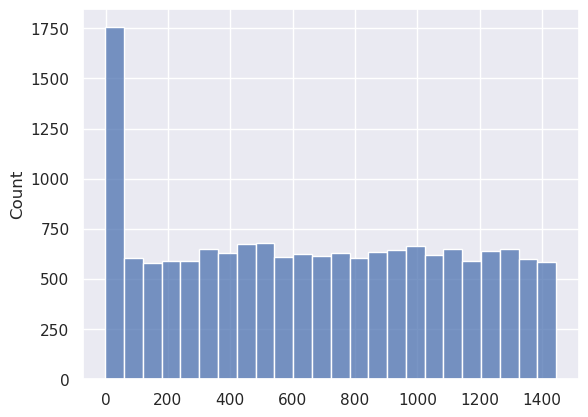

In [301]:
sns.histplot(res)